In [1]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

import xml.etree.ElementTree as ET

In [2]:
MAIN_DIR = '/kaggle/input/VOC2012'

In [3]:
def xml_to_csv(path = os.path.join(MAIN_DIR,'Annotations')):
    
    xml_list = []
    
    for xml_file in tqdm(glob.glob(path + '/2007*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            # it would be better to use column name instead of index
            value = (root.find('filename').text,
                     int(root.find('size').find('depth').text), #0 , 2
                     int(root.find('size').find('width').text), #1 , 0
                     int(root.find('size').find('height').text), #2 , 1
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
            
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    
    return xml_df

In [4]:
xml_df = xml_to_csv()

100%|██████████| 756/756 [00:02<00:00, 288.89it/s]


In [5]:
xml_df

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2007_005144.jpg,3,332,500,person,1,12,331,500
1,2007_005989.jpg,3,500,375,motorbike,140,130,408,273
2,2007_005989.jpg,3,500,375,person,213,96,355,260
3,2007_002107.jpg,3,500,375,aeroplane,408,243,449,257
4,2007_000822.jpg,3,500,374,motorbike,98,165,230,346
...,...,...,...,...,...,...,...,...,...
1989,2007_001583.jpg,3,500,375,person,70,16,232,375
1990,2007_006400.jpg,3,500,335,train,433,80,500,256
1991,2007_006400.jpg,3,500,335,train,189,101,440,235
1992,2007_006400.jpg,3,500,335,train,40,125,199,203


In [6]:
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", 
           "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa",
           "train", "tvmonitor"]
num_classes = len(classes)

person


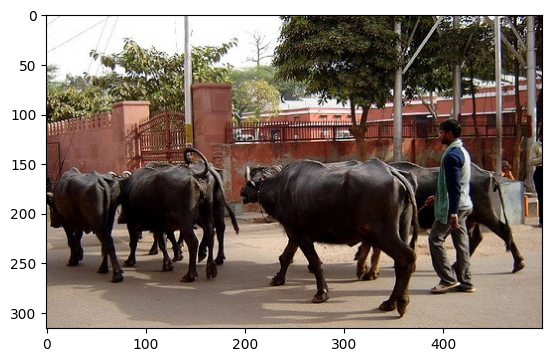

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

print(xml_df.iloc[11]['class'])
image_path = os.path.join(MAIN_DIR,'JPEGImages',xml_df.iloc[11]['filename'])
plt.imshow(Image.open(image_path))
plt.show()

## Teacher Training

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(MAIN_DIR,'JPEGImages',self.dataframe.iloc[idx]['filename'])
        label = self.dataframe.iloc[idx]['class']

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
label_encoder = LabelEncoder().fit(xml_df['class'])
xml_df['class'] = label_encoder.transform(xml_df['class'])

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Assuming using ImageNet normalization
])

dataset = CustomDataset(xml_df, transform = transform)
dataloader = DataLoader(dataset, batch_size = 64, shuffle=True, num_workers=4)


In [12]:
resnet = models.resnet18(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

class ModifiedResnet(nn.Module):
    def __init__(self, resnet):
        super(ModifiedResnet, self).__init__()
        self.resnet = resnet
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.softmax(x)
        return x

resnet = ModifiedResnet(resnet)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [14]:
def train_model(model, criterion, optimizer, num_epochs = 10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

train_model(resnet, criterion, optimizer, num_epochs = 15)

Epoch [1/15], Loss: 2.6852
Epoch [2/15], Loss: 2.6718
Epoch [3/15], Loss: 2.6664
Epoch [4/15], Loss: 2.6660
Epoch [5/15], Loss: 2.6560
Epoch [6/15], Loss: 2.6612
Epoch [7/15], Loss: 2.6357
Epoch [8/15], Loss: 2.6408
Epoch [9/15], Loss: 2.6686
Epoch [10/15], Loss: 2.6686
Epoch [11/15], Loss: 2.6543
Epoch [12/15], Loss: 2.6505
Epoch [13/15], Loss: 2.6414
Epoch [14/15], Loss: 2.6298
Epoch [15/15], Loss: 2.6228


In [15]:
import pickle
with open('teacher.pkl', 'wb') as file:
    pickle.dump(resnet, file)